In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time

In [47]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all" 

In [48]:
# Load cleaned sample
df = pd.read_csv('yellowcab3w.csv')
df

,is_peak_hour,is_night_hour,PU_is_midtown,PU_is_uptown,PU_is_downtown,DO_is_midtown,DO_is_uptown,DO_is_downtown,vendor_2,is_weekend,passenger_count,trip_distance,fare_amount,extra,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,0,0,0,0,0,0,0,1,1,1,-0.402384,-0.161779,-0.254309,-0.902054,-0.265522,0.040308,0.271461,-0.310566,1.82
1,0,1,0,1,0,1,0,0,1,0,-0.402384,-0.370128,-0.379366,-0.340178,-0.265522,0.040308,0.271461,-0.310566,3.42
2,1,0,0,0,1,0,0,0,1,0,-0.402384,-0.374657,-0.337681,0.502637,-0.265522,0.040308,0.271461,-0.310566,2.90
3,0,0,0,0,0,0,0,0,0,1,-0.402384,3.189915,3.068634,0.502637,-0.265522,0.040308,0.271461,-0.310566,0.00
4,0,1,0,0,0,0,1,0,1,0,0.712355,-0.626034,-0.796223,-0.340178,-0.265522,0.040308,0.271461,-0.310566,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,1,1,0,-0.402384,-0.247836,-0.379366,-0.902054,-0.265522,0.040308,0.271461,-0.310566,3.22
29996,0,0,0,0,1,1,0,0,1,0,-0.402384,-0.034959,0.162547,-0.902054,-0.265522,0.040308,0.271461,-0.310566,5.04
29997,0,0,0,0,0,0,0,1,1,1,-0.402384,-0.433538,-0.462738,-0.902054,-0.265522,0.040308,0.271461,-0.310566,2.94
29998,0,0,0,0,1,0,0,0,1,0,-0.402384,-0.528654,-0.629480,-0.902054,-0.265522,0.040308,0.271461,-0.310566,1.00


# EDA

In [49]:
df.columns
len(df.columns)

Index(['is_peak_hour', 'is_night_hour', 'PU_is_midtown', 'PU_is_uptown',
       'PU_is_downtown', 'DO_is_midtown', 'DO_is_uptown', 'DO_is_downtown',
       'vendor_2', 'is_weekend', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'airport_fee', 'tip_amount'],
      dtype='object')

19

In [50]:
df[df.isna().any(axis=1)]

,is_peak_hour,is_night_hour,PU_is_midtown,PU_is_uptown,PU_is_downtown,DO_is_midtown,DO_is_uptown,DO_is_downtown,vendor_2,is_weekend,passenger_count,trip_distance,fare_amount,extra,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount


In [51]:
df["tip_amount"].describe()

count    30000.000000
mean         3.383050
std          3.736364
min          0.000000
25%          1.000000
50%          2.740000
75%          4.200000
max         93.000000
Name: tip_amount, dtype: float64

<Axes: xlabel='tip_amount', ylabel='Count'>

Text(0.5, 1.0, 'Simulated Distribution of Tip Amount')

Text(0.5, 0, 'Tip Amount ($)')

Text(0, 0.5, 'Frequency')

(0.0, 50.0)

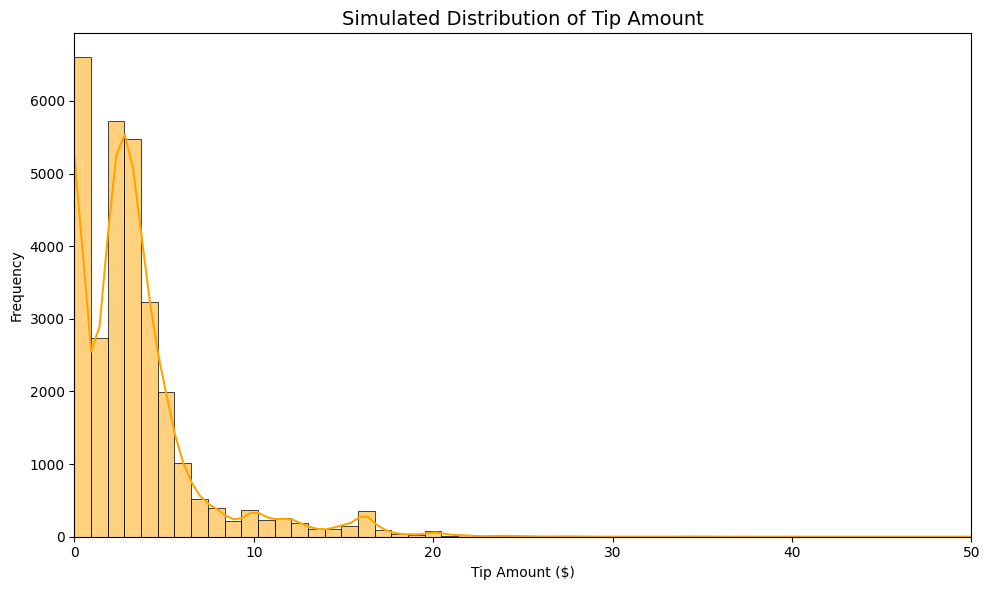

In [52]:
import seaborn as sns 

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df["tip_amount"], bins=100, kde=True, ax=ax, color='orange', edgecolor='black')

ax.set_title('Simulated Distribution of Tip Amount', fontsize=14)
ax.set_xlabel('Tip Amount ($)')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 50)  
plt.tight_layout()
plt.show()

In [53]:
feature_cols = [
    'is_peak_hour', 'is_night_hour', 'PU_is_midtown', 'PU_is_uptown',
    'PU_is_downtown', 'DO_is_midtown', 'DO_is_uptown', 'DO_is_downtown',
    'vendor_2', 'is_weekend', 'trip_distance',
    'fare_amount', 'extra', 'tolls_amount',
    'congestion_surcharge', 'airport_fee'
]

target_col = 'tip_amount'

df_new = df[df["tip_amount"]>0]
q = df_new[target_col].quantile(0.98)
df_new = df_new[df_new[target_col] <= q]
df_new

,is_peak_hour,is_night_hour,PU_is_midtown,PU_is_uptown,PU_is_downtown,DO_is_midtown,DO_is_uptown,DO_is_downtown,vendor_2,is_weekend,passenger_count,trip_distance,fare_amount,extra,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,0,0,0,0,0,0,0,1,1,1,-0.402384,-0.161779,-0.254309,-0.902054,-0.265522,0.040308,0.271461,-0.310566,1.82
1,0,1,0,1,0,1,0,0,1,0,-0.402384,-0.370128,-0.379366,-0.340178,-0.265522,0.040308,0.271461,-0.310566,3.42
2,1,0,0,0,1,0,0,0,1,0,-0.402384,-0.374657,-0.337681,0.502637,-0.265522,0.040308,0.271461,-0.310566,2.90
5,0,0,0,1,0,0,0,0,1,0,0.712355,-0.159515,-0.129252,-0.902054,-0.265522,0.040308,0.271461,-0.310566,2.00
6,0,0,1,1,0,0,0,1,1,0,-0.402384,-0.299924,-0.295995,-0.902054,-0.265522,0.040308,0.271461,-0.310566,4.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,0,1,1,0,0,0,0,0,0,0,-0.402384,1.763180,1.621546,1.064513,-0.265522,0.040308,0.271461,-0.310566,12.65
29995,0,0,0,0,0,0,0,1,1,0,-0.402384,-0.247836,-0.379366,-0.902054,-0.265522,0.040308,0.271461,-0.310566,3.22
29996,0,0,0,0,1,1,0,0,1,0,-0.402384,-0.034959,0.162547,-0.902054,-0.265522,0.040308,0.271461,-0.310566,5.04
29997,0,0,0,0,0,0,0,1,1,1,-0.402384,-0.433538,-0.462738,-0.902054,-0.265522,0.040308,0.271461,-0.310566,2.94


# Model of Choice: XGBoost

## Baseline handwritten functions

In [39]:
# Def four objective functions
def squared_error_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad = 2 * (y_pred - y_true)
    hess = np.full_like(y_pred, 2.0)
    return grad, hess

def squared_log_error_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    eps = 1e-6
    pred = np.clip(y_pred, -1 + eps, np.inf)  
    grad = 2 * (np.log1p(pred) - np.log1p(y_true)) / (1 + pred)
    hess = 2 * (1 - np.log1p(pred) + np.log1p(y_true)) / ((1 + pred) ** 2)
    return grad, hess

def absolute_error_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad = np.sign(y_pred - y_true)
    hess = np.full_like(y_pred, 1e-6)
    return grad, hess

def gamma_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    pred = np.exp(y_pred)
    grad = 1.0 - y_true / pred
    hess = y_true / (pred ** 2)
    return grad, hess

objective_list = {
    'squared_error': squared_error_obj,
    'squared_log_error': squared_log_error_obj,
    # 'absolute_error': absolute_error_obj,
    # 'gamma': gamma_obj
}

In [40]:
# Assuming df_new has already been created: (filtered with tip_amount > 0 and <= 99th percentile)
X = df_new[feature_cols]
y = df_new[target_col]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
)

# DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Hyperparater space
max_depth_list = [4, 5, 6, 7, 8]
learning_rate_list = [0.01, 0.02, 0.05, 0.1, 0.2]
n_estimators_list = [100, 200, 300, 400, 800]

results = []
start_time_total = time.time()

objective_time_summary = {}

for obj_name, obj_func in objective_list.items():
    print(f"\nSearching with Objective: {obj_name}")
    best_r2 = -np.inf
    best_params = None
    total_time_obj = 0
    total_runs = 0

    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for n_estimators in n_estimators_list:
                start = time.time()

                params = {
                    'max_depth': max_depth,
                    'eta': learning_rate,
                    'verbosity': 0}
                
                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=n_estimators,
                    obj=obj_func)

                y_pred = model.predict(dtest)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                r2 = r2_score(y_test, y_pred)
                duration = time.time() - start

                total_time_obj += duration
                total_runs += 1

                # print(f"{obj_name} | depth={max_depth}, lr={learning_rate}, rounds={n_estimators} | RMSE={rmse:.4f}, R²={r2:.4f} | Time={duration:.2f}s")

                results.append({
                    'objective': obj_name,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'rmse': rmse,
                    'r2': r2,
                    'loop_time': duration
                })

                if r2 > best_r2:
                    best_r2 = r2
                    best_params = (max_depth, learning_rate, n_estimators)

    # avg_time = total_time_obj / total_runs
    # objective_time_summary[obj_name] = avg_time
    print(f"Total Avg Time for {obj_name}:{total_time_obj:.2f} seconds")
    # print(f"Avg Time for {obj_name}: {avg_time:.2f} seconds per run")


Searching with Objective: squared_error
Total Avg Time for squared_error:81.14 seconds

Searching with Objective: squared_log_error
Total Avg Time for squared_log_error:83.46 seconds


## Baseline built-in functions

In [ ]:
# Assuming df_new has already been created: (filtered with tip_amount > 0 and <= 99th percentile)
X = df_new[feature_cols]
y = df_new[target_col]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
)

# Objectives names (built in)
objective_list = [
    'reg:squarederror', 
    'reg:squaredlogerror', 
    # 'reg:absoluteerror', 
    # 'reg:gamma'
]

# Start profiling
start_time_total = time.time()
objective_time_summary = {}

# Outer loop: over different objectives
for objective_function in objective_list:
    print(f"\nSearching with Objective: {objective_function}")

    best_r2 = -np.inf
    best_params = None

    total_time_obj = 0
    total_runs = 0

    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for n_estimators in n_estimators_list:
                start_time_loop = time.time()

                model = xgb.XGBRegressor(
                    objective=objective_function,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    random_state=42
                )
                _ = model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)

                rmse = mean_squared_error(y_test, y_pred, squared=False)
                r2 = r2_score(y_test, y_pred)

                duration = time.time() - start_time_loop
                total_time_obj += duration
                total_runs += 1

                # print(f"Objective={objective_function} | max_depth={max_depth}, lr={learning_rate}, n_estimators={n_estimators} | RMSE={rmse:.4f}, R²={r2:.4f} | Loop time={duration:.2f} seconds")

                if r2 > best_r2:
                    best_r2 = r2
                    best_params = (max_depth, learning_rate, n_estimators)

    avg_time = total_time_obj / total_runs
    objective_time_summary[objective_function] = avg_time

    # print(f"\nBest Parameters for {objective_function}: max_depth={best_params[0]}, learning_rate={best_params[1]}, n_estimators={best_params[2]}")
    # print(f"Best R² for {objective_function}: {best_r2:.4f}")
    print(f"Average training time for {objective_function}: {avg_time:.2f} seconds")
    print(f"Total Avg Time for {obj_name}:{total_time_obj:.2f} seconds")
# end_time_total = time.time()
# print(f"\nTotal search time for all objectives: {end_time_total - start_time_total:.2f} seconds")


We now have a really long output for our baseline, however with each loss function each reaching $R^2$ around 0.7, which is a disireable result. 'squarederror' and 'squaredlogerror' have much stable RMSE than the other two, so we choose to only use 'squarederror' and 'squaredlogerror' when evaluating on entire dataset. Our next goal is to **accelerate** the whole process while keeping nice prediction.

## Visualization

Text(0.5, 0, 'Model')

Text(0, 0.5, 'R² Score')

Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, 'Comparison of R² Score and RMSE across Objectives')

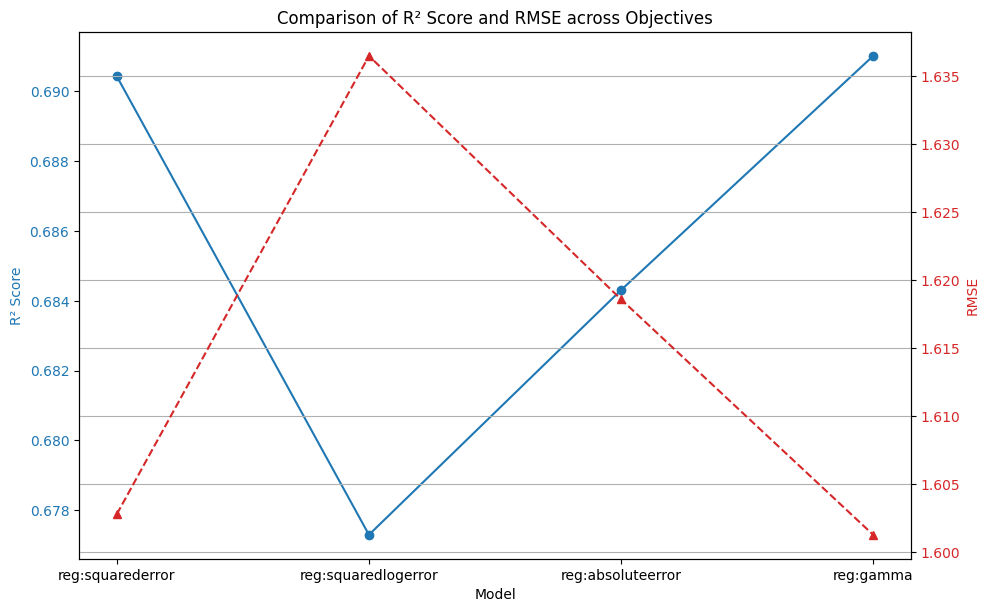

In [34]:
# Plot best rmse and r2 through out the loop

model_names = []
best_r2_list = []
best_rmse_list = []

for obj in results_per_objective.keys():
    model_names.append(obj)
    records = results_per_objective[obj]
    r2_scores = np.array([r[3] for r in records])
    rmse_scores = np.array([r[4] for r in records])

    best_r2_list.append(np.max(r2_scores))
    best_rmse_list.append(rmse_scores[np.argmax(r2_scores)])  

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color_r2 = 'tab:blue'
color_rmse = 'tab:red'

# R² Score
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score', color=color_r2)
ax1.plot(model_names, best_r2_list, color=color_r2, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color_r2)

# RMSE 
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE', color=color_rmse)
ax2.plot(model_names, best_rmse_list, color=color_rmse, marker='^', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_rmse)

fig.tight_layout()
plt.title('Comparison of R² Score and RMSE across Objectives')
plt.grid(True)
plt.show()


In [ ]:
## Implement random search of hyperparameters and conduct early stopping to accelerate loop 

## Try out official RandomSearch instead of self implementing

In [93]:
import time
import random
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score

objectives = ['reg:squarederror', 'reg:squaredlogerror', 'reg:absoluteerror', 'reg:gamma']

param_dist = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500]
}

n_iter_search = 20

start_time_all = time.time()

for obj in objectives:
    print(f"\n===== Searching for Objective: {obj} =====")
    
    base_model = xgb.XGBRegressor(
        objective=obj,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
    )
    
    scorer = make_scorer(r2_score)
    
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring=scorer,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)    
    end_time = time.time()
    
    print(f"Best R² for {obj}: {random_search.best_score_:.4f}")
    print(f"Best Parameters for {obj}: {random_search.best_params_}")
    print(f"Search time for {obj}: {end_time - start_time:.2f} seconds")

end_time_all = time.time()
print(f"\nTotal time for all objectives: {end_time_all - start_time_all:.2f} seconds")



===== Searching for Objective: reg:squarederror =====
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring=make_scorer(r2_score), verbose=1)

Best R² for reg:squarederror: 0.7325
Best Parameters for reg:squarederror: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
Search time for reg:squarederror: 12.32 seconds

===== Searching for Objective: reg:squaredlogerror =====
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          objective='reg:squaredlogerror', ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring=make_scorer(r2_score), verbose=1)

Best R² for reg:squaredlogerror: 0.7155
Best Parameters for reg:squaredlogerror: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
Search time for reg:squaredlogerror: 16.79 seconds

===== Searching for Objective: reg:absoluteerror =====
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          objective='reg:absoluteerror', ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring=make_scorer(r2_score), verbose=1)

Best R² for reg:absoluteerror: 0.7164
Best Parameters for reg:absoluteerror: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.02}
Search time for reg:absoluteerror: 28.18 seconds

===== Searching for Objective: reg:gamma =====
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          objective='reg:gamma', ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring=make_scorer(r2_score), verbose=1)

Best R² for reg:gamma: 0.7321
Best Parameters for reg:gamma: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.02}
Search time for reg:gamma: 17.71 seconds

Total time for all objectives: 74.99 seconds
